# Figure 3

Panel A corresponds to Section 1 of the results
Panels B & C correspond to Section 2 of the results

In [51]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

sys.path.append("../utils")
from myUtils import convert_ode_parameters, obtain_architecture
from LotkaVolterraModel import LotkaVolterraModel
from plotUtils import plot_simulation

In [52]:
def convert_to_rgb_grayscale(col):
    rgb_col = to_rgb(col)
    return tuple([(0.2989 * rgb_col[0]) + (0.5870 * rgb_col[1]) + (0.1140 * rgb_col[2]) for _ in range(3)])

def redistribute_rgb(col):
    r, g, b = col
    threshold = 1 
    m = max(r, g, b)
    if m <= threshold:
        return r, g, b
    total = r + g + b
    if total >= 3 * threshold:
        return threshold, threshold, threshold
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return (gray + x * r), (gray + x * g), (gray + x * b)

/tmp/ipykernel_3272797/3830697167.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([''] + list(colors.keys()));


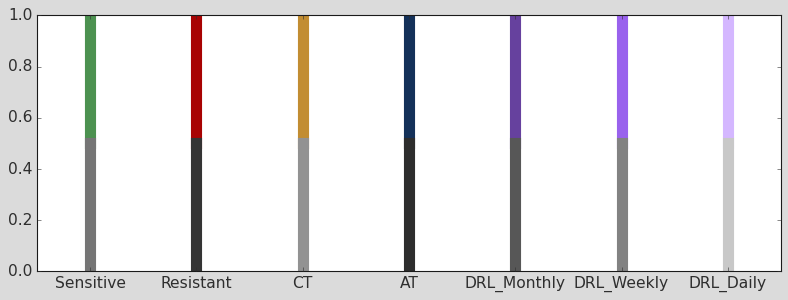

In [53]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

colors['DRL_Weekly'] = redistribute_rgb(tuple([1.5 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Daily'] = redistribute_rgb(tuple([2.0 * x for x in to_rgb(colors['DRL_Monthly'])]))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for i, col in enumerate(colors.values()):
    plt.axvline(i+1, 0.5, 1, color = col, linewidth=10)
    plt.axvline(i+1, 0, 0.5, color = convert_to_rgb_grayscale(col), linewidth=10)
plt.xlim(0.5, len(colors.values()) + 0.5)
plt.gca().set_xticklabels([''] + list(colors.keys()));

In [58]:
print(colors['DRL_Daily'])

(0.8305040136860113, 0.7185155941571258, 1.0)


## Panel A - Cancer Reserach patient trained at different treatment frequencies

In [55]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(os.pardir, file_path, "models")
results_path = os.path.join(file_path, "data", "Fig2")
runFromScratch = True

models = {1: ('ThuMar311244502022', 2600), 7:('MonApr251644332022', 21300), 28:('TueApr261403442022', 115600)}
n_replicates = 100

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)

In [56]:
print(odeParamDic)

{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'k': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075}


In [4]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop


for updating_interval, model in models.items():
    model_name, n_epochs = model
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic,'PatientId':0}]).to_dict(),
              'architecture_kws':obtain_architecture(model_name),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig2", "params", "params_pCR_%s_%s.json"%(n_epochs, updating_interval))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_%s_%s.json"%(n_epochs, updating_interval)
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)), index_col=0)
        
# For these historical models (daily and weekly), we need to adapt evaluation code so that normalisation is not used. This is L473 of drlUtils.py (in run_evaluation())
# We also change ODE evaluation interval (removing argument in L427) so info with the same interval is fed in)

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_2600_1.json
Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_21300_7.json
Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_115600_28.json


In [5]:
# Compute performance under rule of thumb
at_model = LotkaVolterraModel(method='RK45')
at_model.SetParams(**odeParamDic)
at_model.Simulate_AT(atThreshold=0.5, intervalLength=updating_interval, t_end=5000);
at_model.Trim(dt=1)

# Compute performance under continuous therapy
ct_model = LotkaVolterraModel(method='RK45')
ct_model.SetParams(**odeParamDic)
ct_model.Simulate([[0, 2000, 1]])
ct_model.Trim(dt=1)
ct_model.ttp = max(ct_model.resultsDf['Time'][ct_model.resultsDf['TumourSize'] < ct_model.resultsDf['TumourSize'][0] * 1.2])

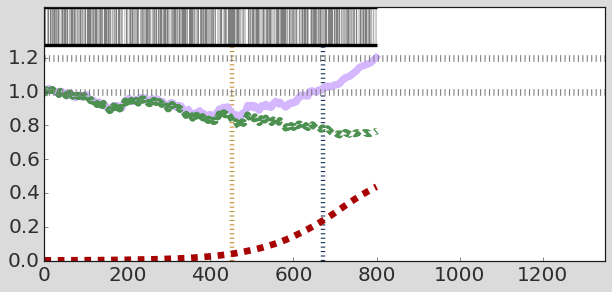

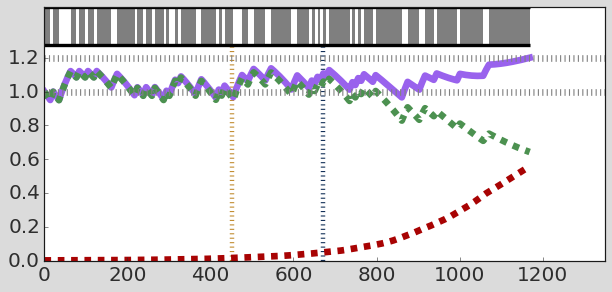

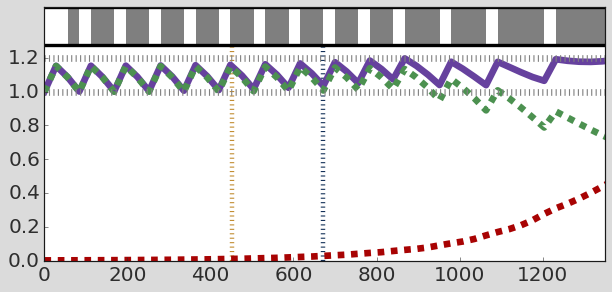

In [57]:
plt.rcParams['font.size'] = '18'
time_interals = {1:'Daily', 7:'Weekly', 28:'Monthly'}
for updating_interval, model in models.items():
    model_name, n_epochs = model
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= odeParamDic['n0']
    # Plot example trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,4))
    palette = {"TumourSize": colors["DRL_" + time_interals[updating_interval]], "S": colors["Sensitive"], "R": colors["Resistant"]}
    plot_simulation(currDataDf[currDataDf.ReplicateId == 2], plotPops=True, lineplot_kws={'estimator':None, 'units':"ReplicateId", 'lw': 6, 'palette': palette},
                    decorateAxes=False, decoratey2=False ,markInitialSize=True, markProgression=True, ylim=[0,1.5], xlim=[0, 1350], ax=ax)
    
    ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
    ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)

    
    ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.tick_params(right = False, top = False)
    plt.savefig("figures/fig2a_pCR_%s.pdf"%updating_interval)

## Panel B - Box plot comparing the different evaluation frequencies

In [7]:
results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%('TueApr261403442022', 115600, 28)
df = pd.read_csv(os.path.join(results_path,results_file_name))
df.drop(df.loc[df['ReplicateId'].isin([12, 19, 38, 45, 46, 49, 53, 57, 58, 66, 88])].index, inplace=True)
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
df.to_csv(os.path.join(results_path,results_file_name))

In [8]:
data_frames = []; 
interval_labels = {1: "Daily", 7:"Weekly", 28:"Monthly"}
for updating_interval, model in models.items():
    model_name, n_epochs = model
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    df = pd.read_csv(os.path.join(results_path,results_file_name))
    box_plot_df = df.drop_duplicates('ReplicateId', keep='last')
    box_plot_df.insert(1, "Model", interval_labels[updating_interval])
    
    # box_plot_df = box_plot_df.drop_duplicates(subset=['Time', 'Model'], keep='last')
    data_frames.append(box_plot_df)

total_df = pd.concat(data_frames)

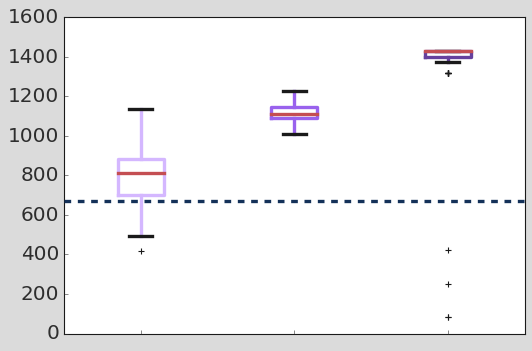

In [46]:
box_plot_colors = [colors["DRL_" + time_interals[updating_interval]] for updating_interval in models.keys()]
box_plot_colors = [box_plot_colors[i] for i in [0, 2, 1]]
bp_dict = total_df.plot.box(column="Time", by="Model", positions = [1,3,2], figsize=(7,5),
                 boxprops= dict(linewidth=3), whiskerprops=dict(linestyle='-', linewidth=3),
                 medianprops= dict(linewidth=3), capprops= dict(linewidth=3), return_type='both')
for row_key, (ax,row) in bp_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_color(box_plot_colors[i])
    for j,box in enumerate(row['whiskers']):
        box.set_color(box_plot_colors[j//2])

plt.axhline(y=at_model.ttp, color = colors['AT'], linestyle='--', linewidth = 3, zorder=3)

plt.title(""); plt.suptitle("")
# plt.ylabel("Time to Progression (days)"); plt.xlabel("Treatment Frequency")
plt.gca().set_xticklabels([]); plt.gca().tick_params(top=False, right=False)
plt.ylim(bottom=0); plt.tight_layout()
plt.savefig("figures/fig2b_interval_boxplot.pdf")

## Panel C - Kaplan-Meier Plots

In [10]:
# Compute performance under rule of thumb

def evaluate_model(n_reps, param_dic, save_loc):
    """Saves virtual patient data under nominated treatment scheme to csv
    in comparable format to the Deep Learning Model"""
    patient_dfs = []
    for i in tqdm(range(n_reps)):
        at_model = LotkaVolterraModel(method='RK45')
        at_model.SetParams(**odeParamDic)
        at_model.Simulate_AT(atThreshold=0.5, intervalLength=day_interval)
        at_model.Trim(dt=1)
        at_model.resultsDf.insert(1, "ReplicateId", i)
        patient_dfs.append(at_model.resultsDf)
    
    total_df = pd.concat(patient_dfs)
    total_df.to_csv(save_loc)

In [23]:
# Kaplan Meier Functions
def kaplan_meier_max_time(df_list):
    """Finds max patient survival time from all
    treatment schedules"""
    t = 0
    for df in df_list:
        t = max(0, df['Time'].max())
    return t


def kaplan_meier_calc(complete_df, final_time, dt):
    """Takes dataframe and returns plottable array for
    Kaplan Meier plot."""
    final_df = complete_df.drop_duplicates('ReplicateId', keep='last')
    array = np.zeros((2, int(final_time) + 1))
    array[0, :] = np.arange(0, final_time + dt, dt)
    for i, t in enumerate(array[0, :]):
        array[1, i] = final_df[final_df["Time"] > t].shape[0] / final_df.shape[0]
    return array

def kaplan_meier_plot(results_loc, model_names, model_labels, colors, save_loc, dt=1):
    """Generates Kaplan Meier plots for any number of 
    model results provided."""
    df_list = []
    for model in model_names:
        df_list.append(pd.read_csv(os.path.join(results_loc, (model + ".csv"))))
    
    max_time = kaplan_meier_max_time(df_list)
    styles = ['-', '--', '-.']
    fix, ax = plt.subplots(1,1,figsize=(7,5))
    for i in range(len(model_names)):
        plot_data = kaplan_meier_calc(df_list[i], max_time, dt)
        plt.plot(plot_data[0, :], plot_data[1, :],linewidth = 4, linestyle = '-', #styles[i],
                label=(model_labels[i]), color=colors[i])

    # plt.axvline(x=at_model.ttp, color = colors[-1], linestyle=':', linewidth = 6, zorder=3, label = "Adaptive Therapy")
    plt.xlim(0, 1500); plt.ylim(0, 1.03)
    plt.gca().legend(loc=3, ncol=1, bbox_to_anchor=(0.03,0.03)).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
    
    
    plt.tight_layout()

    file_name = "fig2c_km_comparison" + "_".join(model_labels) + "_.pdf"
    plt.savefig(os.path.join(save_loc, file_name))

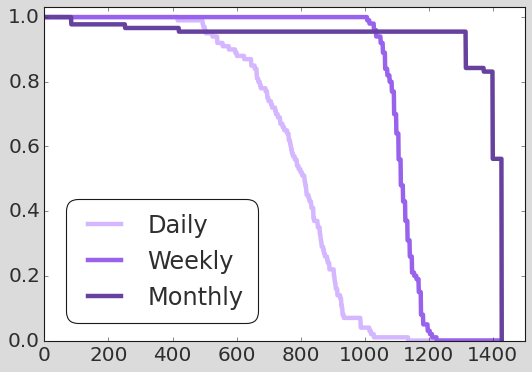

In [25]:
# Kaplan Meier Plot

weekly_col = redistribute_rgb(tuple([1.5 * x for x in to_rgb(colors['DRL'])]))
daily_col = redistribute_rgb(tuple([2.0 * x for x in to_rgb(colors['DRL'])]))
km_cols = [daily_col, weekly_col, colors['DRL'], colors['AT']]

model_names = []
for updating_interval, model in models.items():
    model_name, n_epochs = model
    model_names.append('resultsDf_%s_crBase_%d_patients_int_%d'%(model_name,n_epochs, updating_interval))
    
model_labels = list(interval_labels.values())
save_loc = "figures/"

kaplan_meier_plot(results_path, model_names, model_labels, km_cols, os.path.join(file_path, "figures"))